# Traffic Congestion Prediction — End-to-End ML Project
**Dataset:** UCI Metro Interstate Traffic Volume  
**Models:** Random Forest · XGBoost · LSTM · Prophet (ARIMA-style Time Series)  
**Goal:** Predict hourly traffic volume and classify congestion levels

---
### Table of Contents
1. Environment Setup & Imports
2. Data Loading & Overview
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Preprocessing
6. Model 1 — Random Forest
7. Model 2 — XGBoost
8. Model 3 — LSTM (Deep Learning)
9. Model 4 — Prophet (Time Series)
10. Model Comparison & Evaluation
11. Congestion Classification
12. Final Summary & Conclusions

## 1. Environment Setup & Imports

In [54]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.rcParams.update({'figure.dpi': 120, 'figure.figsize': (14, 5)})
sns.set_style('whitegrid')
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from prophet import Prophet
from datetime import datetime
import itertools

np.random.seed(42)
tf.random.set_seed(42)

print('All libraries imported successfully!')
print(f'TensorFlow version : {tf.__version__}')
print(f'XGBoost version    : {xgb.__version__}')

All libraries imported successfully!
TensorFlow version : 2.19.0
XGBoost version    : 3.2.0


## 2. Data Loading & Overview



In [55]:
import urllib.request, os

URL  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'
FILE = 'Metro_Interstate_Traffic_Volume.csv'

if not os.path.exists(FILE):
    print('Downloading dataset …')
    import gzip, shutil
    urllib.request.urlretrieve(URL, FILE + '.gz')
    with gzip.open(FILE + '.gz', 'rb') as f_in:
        with open(FILE, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove(FILE + '.gz')
    print('Download complete!')
else:
    print('Dataset already present.')

Dataset already present.


In [56]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'])

print(f'Shape          : {df.shape}')
print(f'Date range     : {df["date_time"].min()}  →  {df["date_time"].max()}')
print(f'\nColumn dtypes:\n{df.dtypes}')
df.head(10)

Shape          : (48204, 9)
Date range     : 2012-10-02 09:00:00  →  2018-09-30 23:00:00

Column dtypes:
holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
dtype: object


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,NaN,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,NaN,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,NaN,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,NaN,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,NaN,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


In [57]:
print('=== Descriptive Statistics ===')
display(df.describe())

print('\n=== Missing Values ===')
print(df.isnull().sum())

print('\n=== Unique Values per Column ===')
for col in df.columns:
    print(f'  {col:<25} : {df[col].nunique()} unique')

=== Descriptive Statistics ===


,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,2016-01-05 10:46:16.773711616,3259.818355
min,0.000000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,0.000000
25%,272.160000,0.000000,0.000000,1.000000,2014-02-06 11:45:00,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,2016-06-11 03:30:00,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,2017-08-11 06:00:00,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,2018-09-30 23:00:00,7280.000000
std,13.338232,44.789133,0.008168,39.015750,NaN,1986.860670



=== Missing Values ===
holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64

=== Unique Values per Column ===
  holiday                   : 11 unique
  temp                      : 5843 unique
  rain_1h                   : 372 unique
  snow_1h                   : 12 unique
  clouds_all                : 60 unique
  weather_main              : 11 unique
  weather_description       : 38 unique
  date_time                 : 40575 unique
  traffic_volume            : 6704 unique


## 3. Exploratory Data Analysis (EDA)

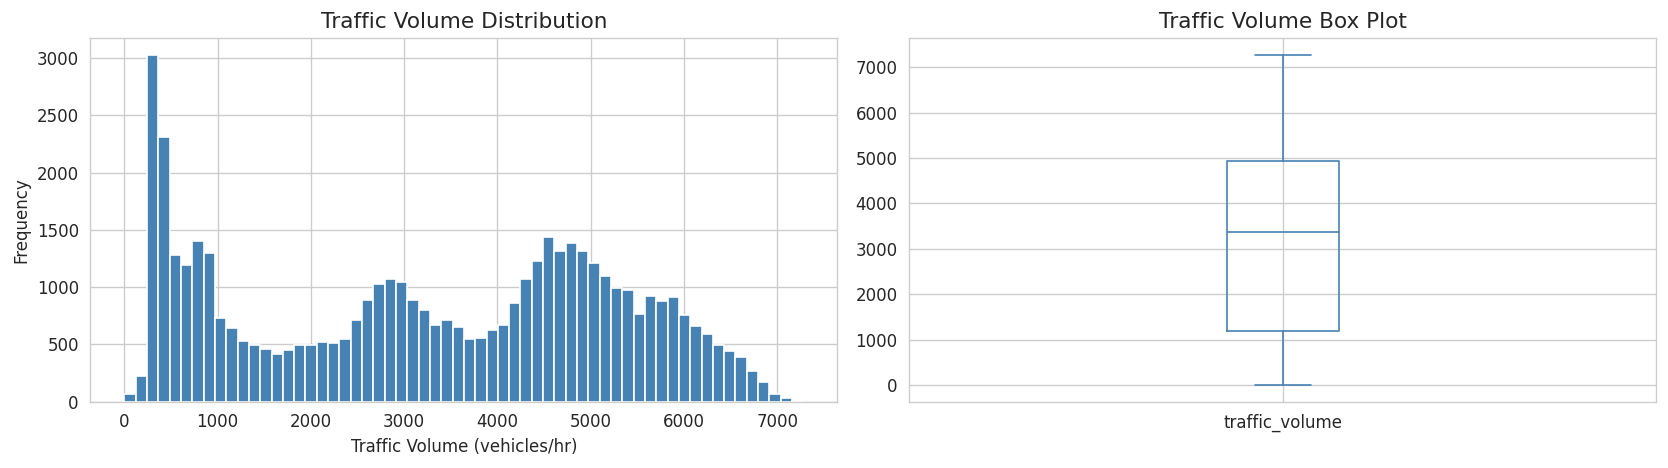

Mean traffic volume  : 3260
Median traffic volume: 3380
Std traffic volume   : 1987


In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df['traffic_volume'], bins=60, color='steelblue', edgecolor='white')
axes[0].set_title('Traffic Volume Distribution', fontsize=13)
axes[0].set_xlabel('Traffic Volume (vehicles/hr)')
axes[0].set_ylabel('Frequency')

df['traffic_volume'].plot(kind='box', ax=axes[1], color='steelblue')
axes[1].set_title('Traffic Volume Box Plot', fontsize=13)

plt.tight_layout()
plt.show()
print(f'Mean traffic volume  : {df["traffic_volume"].mean():.0f}')
print(f'Median traffic volume: {df["traffic_volume"].median():.0f}')
print(f'Std traffic volume   : {df["traffic_volume"].std():.0f}')

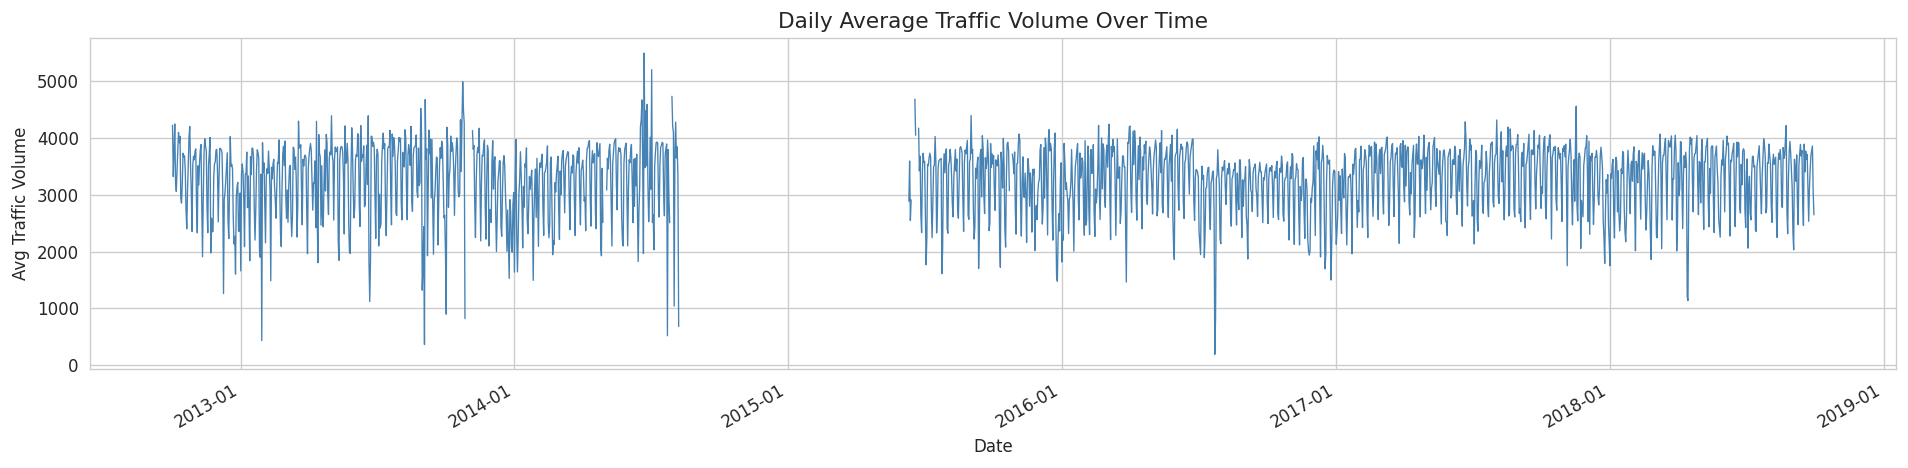

In [59]:
df_plot = df.set_index('date_time').resample('D')['traffic_volume'].mean()
plt.figure(figsize=(16, 4))
plt.plot(df_plot.index, df_plot.values, linewidth=0.8, color='steelblue')
plt.title('Daily Average Traffic Volume Over Time', fontsize=13)
plt.xlabel('Date')
plt.ylabel('Avg Traffic Volume')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

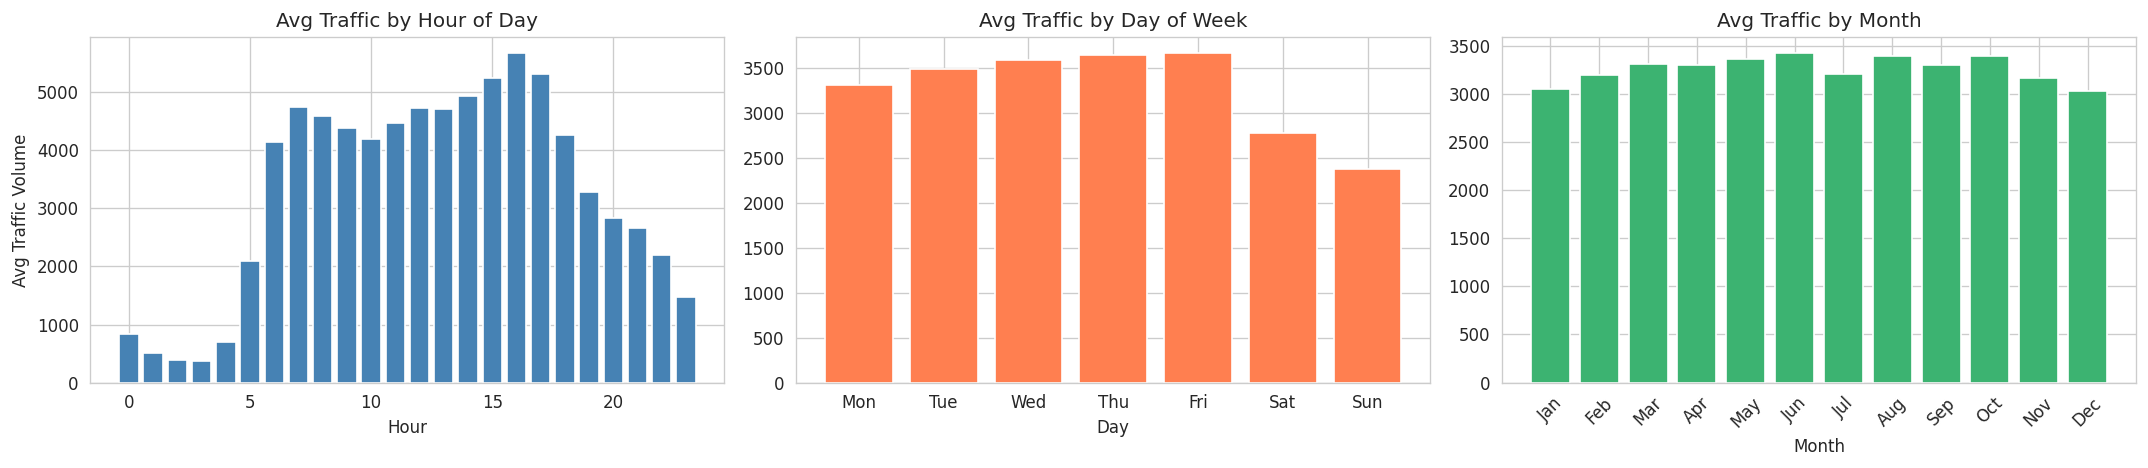

In [60]:
df['hour']        = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek  # (0=Mon, 6=Sun)
df['month']       = df['date_time'].dt.month
df['year']        = df['date_time'].dt.year

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Hourly
hourly = df.groupby('hour')['traffic_volume'].mean()
axes[0].bar(hourly.index, hourly.values, color='steelblue', edgecolor='white')
axes[0].set_title('Avg Traffic by Hour of Day', fontsize=12)
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Avg Traffic Volume')

# Day of Week
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow = df.groupby('day_of_week')['traffic_volume'].mean()
axes[1].bar(day_labels, dow.values, color='coral', edgecolor='white')
axes[1].set_title('Avg Traffic by Day of Week', fontsize=12)
axes[1].set_xlabel('Day')

# Monthly
monthly = df.groupby('month')['traffic_volume'].mean()
axes[2].bar(monthly.index, monthly.values, color='mediumseagreen', edgecolor='white')
axes[2].set_title('Avg Traffic by Month', fontsize=12)
axes[2].set_xlabel('Month')
axes[2].set_xticks(range(1,13))
axes[2].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                          'Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)

plt.tight_layout()
plt.show()

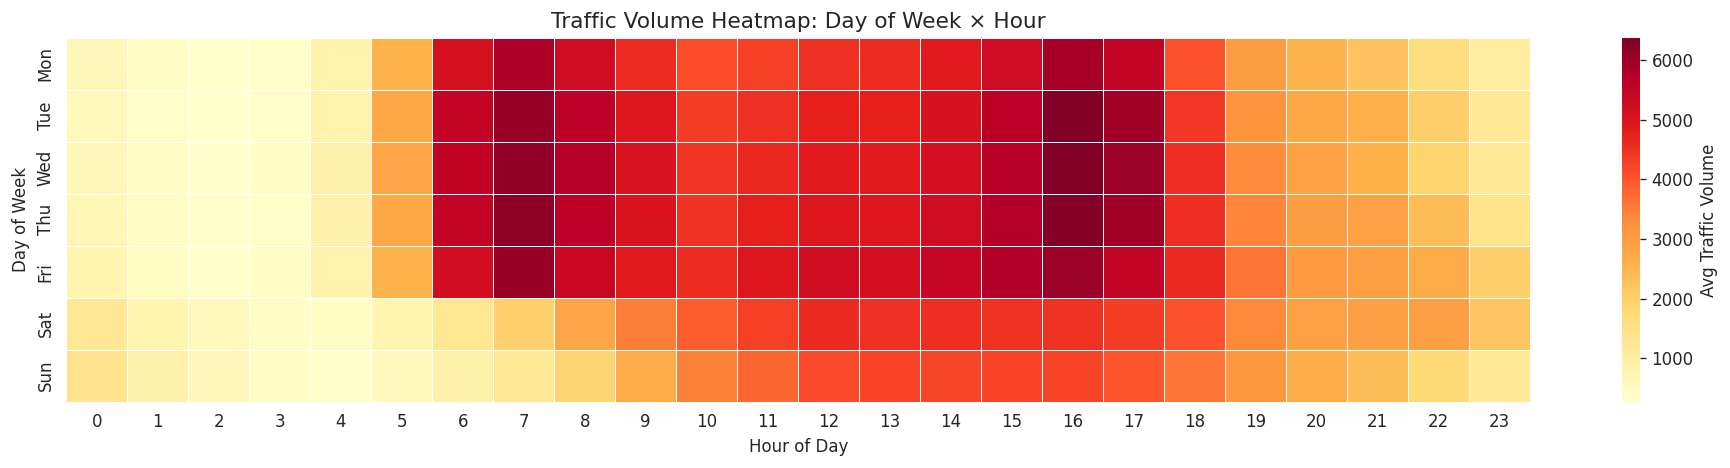

In [61]:
pivot = df.pivot_table(values='traffic_volume', index='day_of_week',
                       columns='hour', aggfunc='mean')
pivot.index = day_labels

plt.figure(figsize=(16, 4))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.3, annot=False, fmt='.0f',
            cbar_kws={'label': 'Avg Traffic Volume'})
plt.title('Traffic Volume Heatmap: Day of Week × Hour', fontsize=13)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

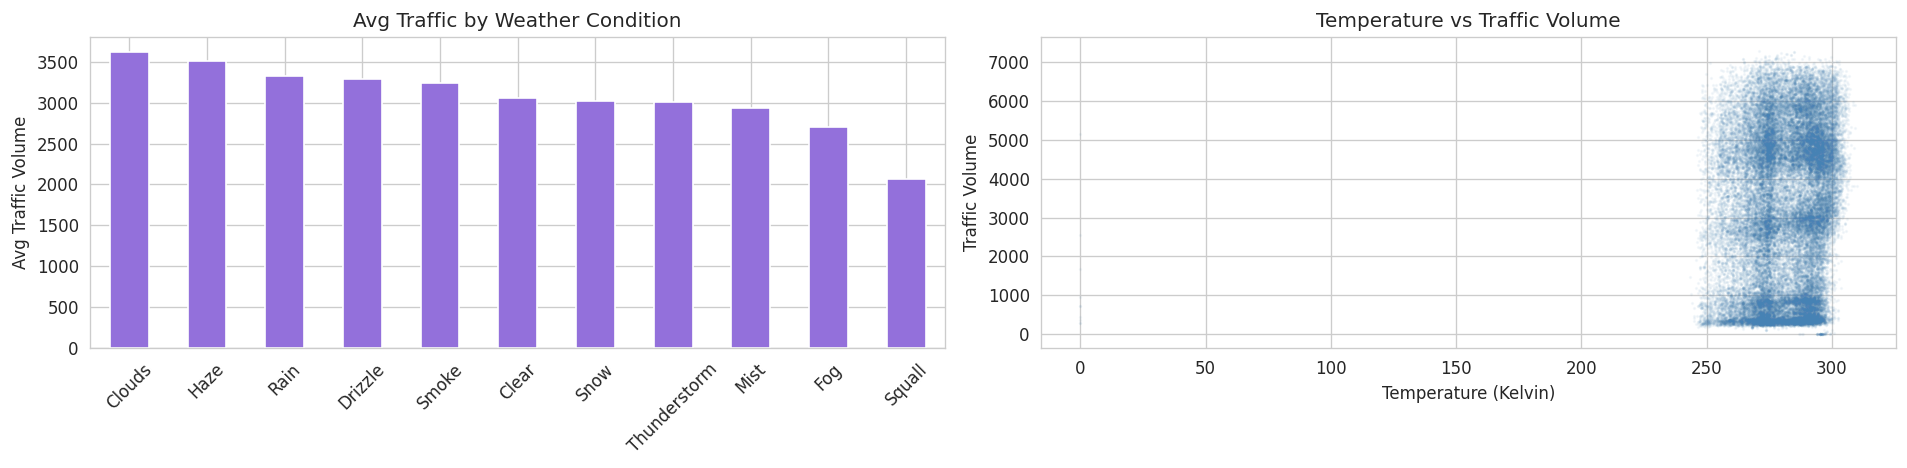

Correlation — Temperature vs Traffic Volume: 0.1303


In [62]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Weather main category
weather_avg = df.groupby('weather_main')['traffic_volume'].mean().sort_values(ascending=False)
weather_avg.plot(kind='bar', ax=axes[0], color='mediumpurple', edgecolor='white')
axes[0].set_title('Avg Traffic by Weather Condition', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Avg Traffic Volume')
axes[0].tick_params(axis='x', rotation=45)

# Temperature vs Traffic
axes[1].scatter(df['temp'], df['traffic_volume'], alpha=0.05, color='steelblue', s=1)
axes[1].set_title('Temperature vs Traffic Volume', fontsize=12)
axes[1].set_xlabel('Temperature (Kelvin)')
axes[1].set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()

print('Correlation — Temperature vs Traffic Volume:',
      df[['temp','traffic_volume']].corr().iloc[0,1].round(4))

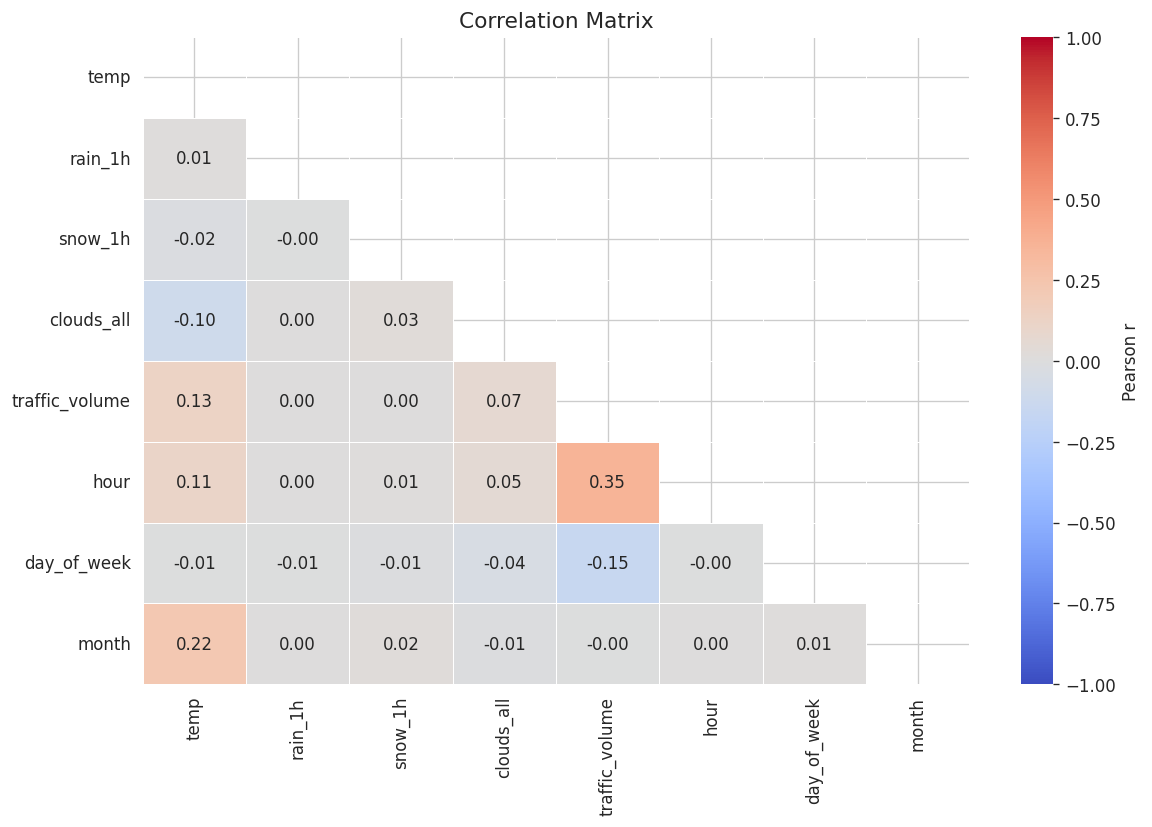

In [63]:
num_cols = ['temp','rain_1h','snow_1h','clouds_all','traffic_volume','hour','day_of_week','month']
corr = df[num_cols].corr()

plt.figure(figsize=(10, 7))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'label': 'Pearson r'})
plt.title('Correlation Matrix', fontsize=13)
plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [64]:
df = df.sort_values('date_time').reset_index(drop=True)

# Time Features
df['hour']        = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month']       = df['date_time'].dt.month
df['year']        = df['date_time'].dt.year
df['quarter']     = df['date_time'].dt.quarter
df['day_of_year'] = df['date_time'].dt.dayofyear
df['week']        = df['date_time'].dt.isocalendar().week.astype(int)

# Is Weekend / Rush Hour
df['is_weekend']   = (df['day_of_week'] >= 5).astype(int)
df['is_rush_hour'] = df['hour'].apply(lambda h: 1 if h in [7,8,9,16,17,18,19] else 0)
df['is_night']     = df['hour'].apply(lambda h: 1 if h < 6 or h >= 22 else 0)

# Cyclical Encoding (hour, day, month → sine/cosine) to ensure the traffic of that day gets poured onto the next day
df['hour_sin']   = np.sin(2 * np.pi * df['hour']        / 24)
df['hour_cos']   = np.cos(2 * np.pi * df['hour']        / 24)
df['dow_sin']    = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos']    = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin']  = np.sin(2 * np.pi * df['month']       / 12)
df['month_cos']  = np.cos(2 * np.pi * df['month']       / 12)

# Lag Features (past 1, 2, 3, 24 hours)
for lag in [1, 2, 3, 24, 48]:
    df[f'lag_{lag}h'] = df['traffic_volume'].shift(lag)

# Rolling Statistics
for window in [3, 6, 12, 24]:
    df[f'rolling_mean_{window}h'] = df['traffic_volume'].shift(1).rolling(window).mean()
    df[f'rolling_std_{window}h']  = df['traffic_volume'].shift(1).rolling(window).std()

# Temperature in Celsius
df['temp_celsius'] = df['temp'] - 273.15

# Holiday Indicator (US federal holidays — approximate)
us_holidays = ['01-01','07-04','12-25','11-11','05-30','09-05','01-16','02-20','10-09','11-23']
df['is_holiday'] = df['date_time'].apply(
    lambda x: 1 if x.strftime('%m-%d') in us_holidays else 0
)

# Encode Categorical Columns
df['holiday_encoded']      = (df['holiday'] != 'None').astype(int)
df['weather_main_encoded'] = LabelEncoder().fit_transform(df['weather_main'])
df['weather_desc_encoded'] = LabelEncoder().fit_transform(df['weather_description'])

# Drop rows with NaN from lag/rolling features
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(f'Feature engineering complete. Shape: {df.shape}')
print(f'Total features created: {df.shape[1]}')
df.head(3)

Feature engineering complete. Shape: (61, 43)
Total features created: 43


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,...,rolling_std_6h,rolling_mean_12h,rolling_std_12h,rolling_mean_24h,rolling_std_24h,temp_celsius,is_holiday,holiday_encoded,weather_main_encoded,weather_desc_encoded
0,Columbus Day,273.08,0.0,0.0,20,Clouds,few clouds,2012-10-08,455,0,...,1147.841220,3816.250000,1795.677240,3018.041667,1866.734034,-0.07,0,1,1,4
1,Veterans Day,288.12,0.0,0.0,87,Clear,sky is clear,2012-11-12,1000,0,...,608.869006,3296.750000,734.228367,3328.750000,659.115168,14.97,0,1,0,27
2,Thanksgiving Day,278.54,0.0,0.0,20,Mist,mist,2012-11-22,919,0,...,980.451461,4153.416667,1699.654053,4743.250000,1353.287503,5.39,0,1,5,17


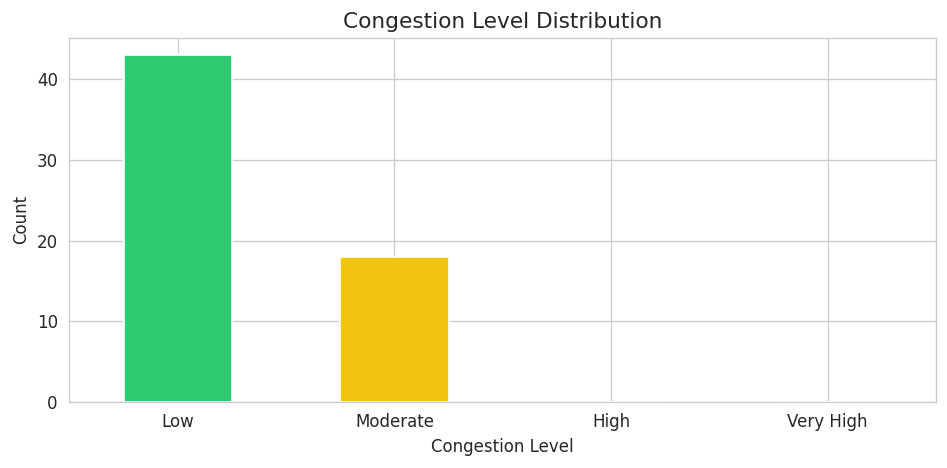

congestion_level
Low          43
Moderate     18
High          0
Very High     0
Name: count, dtype: int64


In [65]:
bins   = [0, 1000, 3000, 5000, 7280]
labels = ['Low', 'Moderate', 'High', 'Very High']
df['congestion_level'] = pd.cut(df['traffic_volume'], bins=bins, labels=labels)

# Distribution of congestion levels
plt.figure(figsize=(8, 4))
df['congestion_level'].value_counts().sort_index().plot(
    kind='bar', color=['#2ecc71','#f1c40f','#e67e22','#e74c3c'], edgecolor='white')
plt.title('Congestion Level Distribution', fontsize=13)
plt.xlabel('Congestion Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(df['congestion_level'].value_counts())

## 5. Preprocessing & Train/Test Split

In [70]:
FEATURE_COLS = [
    # Weather
    'temp_celsius', 'rain_1h', 'snow_1h', 'clouds_all',
    'weather_main_encoded', 'weather_desc_encoded',
    # Time
    'hour', 'day_of_week', 'month', 'quarter', 'year',
    'day_of_year', 'week',
    # Cyclical
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    # Boolean
    'is_weekend', 'is_rush_hour', 'is_night', 'holiday_encoded', 'is_holiday',
    # Lags
    'lag_1h', 'lag_2h', 'lag_3h', 'lag_24h', 'lag_48h',
    # Rolling
    'rolling_mean_3h',  'rolling_std_3h',
    'rolling_mean_6h',  'rolling_std_6h',
    'rolling_mean_12h', 'rolling_std_12h',
    'rolling_mean_24h', 'rolling_std_24h',
]

TARGET = 'traffic_volume'

X = df[FEATURE_COLS]
y = df[TARGET]
y_class = df['congestion_level'].cat.codes  # ordinal codes for classification

n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]
y_cls_train, y_cls_val, y_cls_test = y_class[:train_end], y_class[train_end:val_end], y_class[val_end:]

print(f'Training   samples : {len(X_train):,}')
print(f'Validation samples : {len(X_val):,}')
print(f'Test       samples : {len(X_test):,}')

# Scale Features
scaler   = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)



Training   samples : 42
Validation samples : 9
Test       samples : 10


## 6. Model 1 — Random Forest Regressor

In [69]:
# Random Forest
print('Training Random Forest …')

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=4,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

# Evaluation
rf_pred_val  = rf.predict(X_val)
rf_pred_test = rf.predict(X_test)

rf_metrics = {
    'Val  MAE'  : mean_absolute_error(y_val,  rf_pred_val),
    'Val  RMSE' : np.sqrt(mean_squared_error(y_val,  rf_pred_val)),
    'Val  R²'   : r2_score(y_val,  rf_pred_val),
    'Test MAE'  : mean_absolute_error(y_test, rf_pred_test),
    'Test RMSE' : np.sqrt(mean_squared_error(y_test, rf_pred_test)),
    'Test R²'   : r2_score(y_test, rf_pred_test),
}
print('\n  ---------- Random Forest Metrics ----------')
for k, v in rf_metrics.items():
    print(f'  {k:<12}: {v:.4f}')

Training Random Forest …

  ---------- Random Forest Metrics ----------
  Val  MAE    : 216.0054
  Val  RMSE   : 264.5852
  Val  R²     : 0.3338
  Test MAE    : 161.9905
  Test RMSE   : 197.4187
  Test R²     : 0.5181


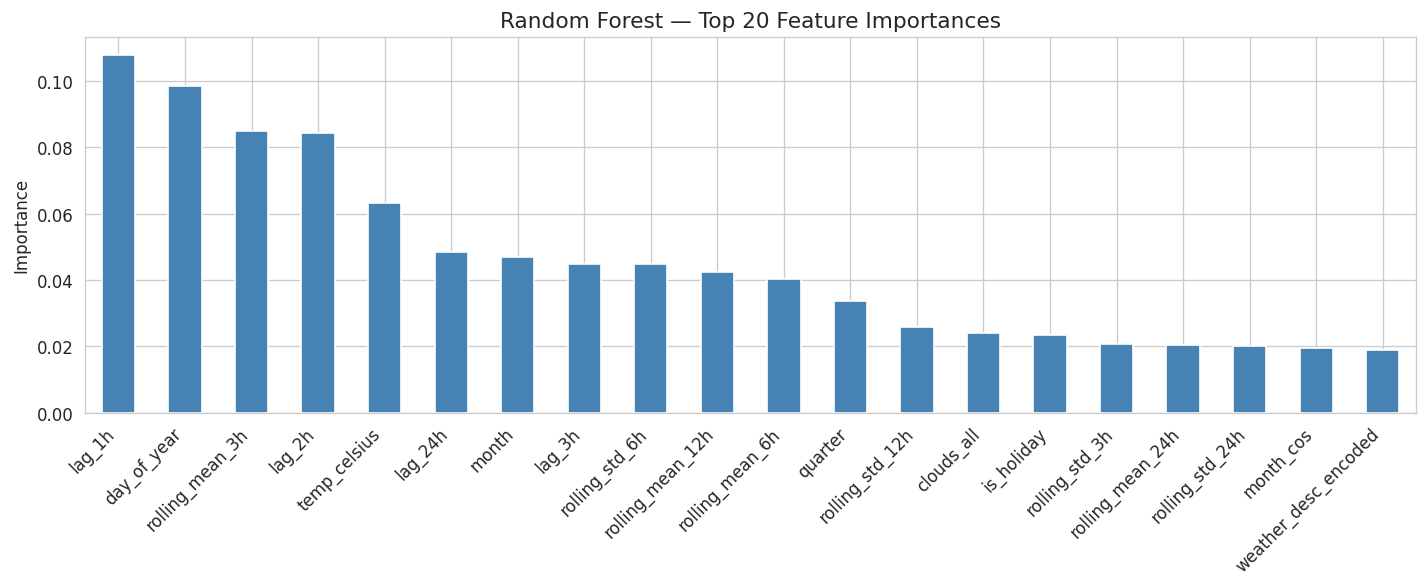

In [15]:
# Feature Importance
feat_imp = pd.Series(rf.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)

plt.figure(figsize=(12, 5))
feat_imp.head(20).plot(kind='bar', color='steelblue', edgecolor='white')
plt.title('Random Forest — Top 20 Feature Importances', fontsize=13)
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

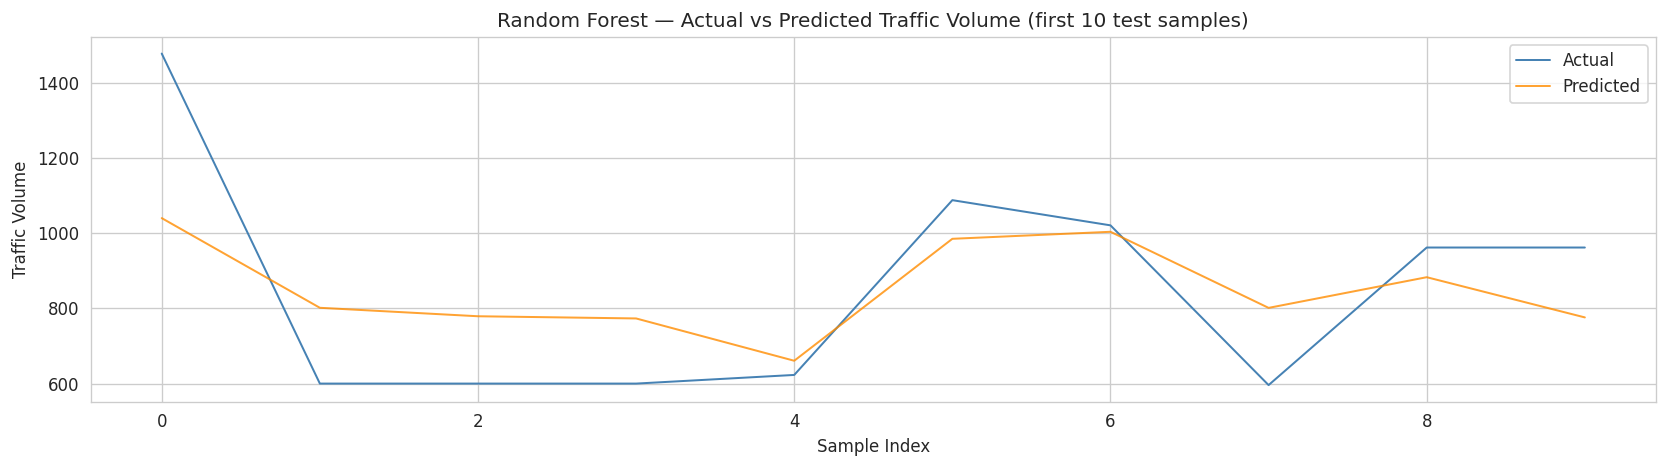

In [72]:
# Actual vs Predicted Plot
sample = min(500, len(y_test))
idx = range(sample)

plt.figure(figsize=(14, 4))
plt.plot(idx, y_test.values[:sample], label='Actual',    color='steelblue',  linewidth=1.2)
plt.plot(idx, rf_pred_test[:sample],  label='Predicted', color='darkorange', linewidth=1.2, alpha=0.8)
plt.title('Random Forest — Actual vs Predicted Traffic Volume (first {} test samples)'.format(sample), fontsize=12)
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Model 2 — XGBoost Regressor

In [73]:
# XGBoost
print('Training XGBoost …')

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

xgb_pred_val  = xgb_model.predict(X_val)
xgb_pred_test = xgb_model.predict(X_test)

xgb_metrics = {
    'Val  MAE'  : mean_absolute_error(y_val,  xgb_pred_val),
    'Val  RMSE' : np.sqrt(mean_squared_error(y_val,  xgb_pred_val)),
    'Val  R²'   : r2_score(y_val,  xgb_pred_val),
    'Test MAE'  : mean_absolute_error(y_test, xgb_pred_test),
    'Test RMSE' : np.sqrt(mean_squared_error(y_test, xgb_pred_test)),
    'Test R²'   : r2_score(y_test, xgb_pred_test),
}
print('\n ---------- XGBoost Metrics ----------')
for k, v in xgb_metrics.items():
    print(f'  {k:<12}: {v:.4f}')

Training XGBoost …

 ---------- XGBoost Metrics ----------
  Val  MAE    : 206.8146
  Val  RMSE   : 285.0372
  Val  R²     : 0.2269
  Test MAE    : 91.7258
  Test RMSE   : 99.7828
  Test R²     : 0.8769


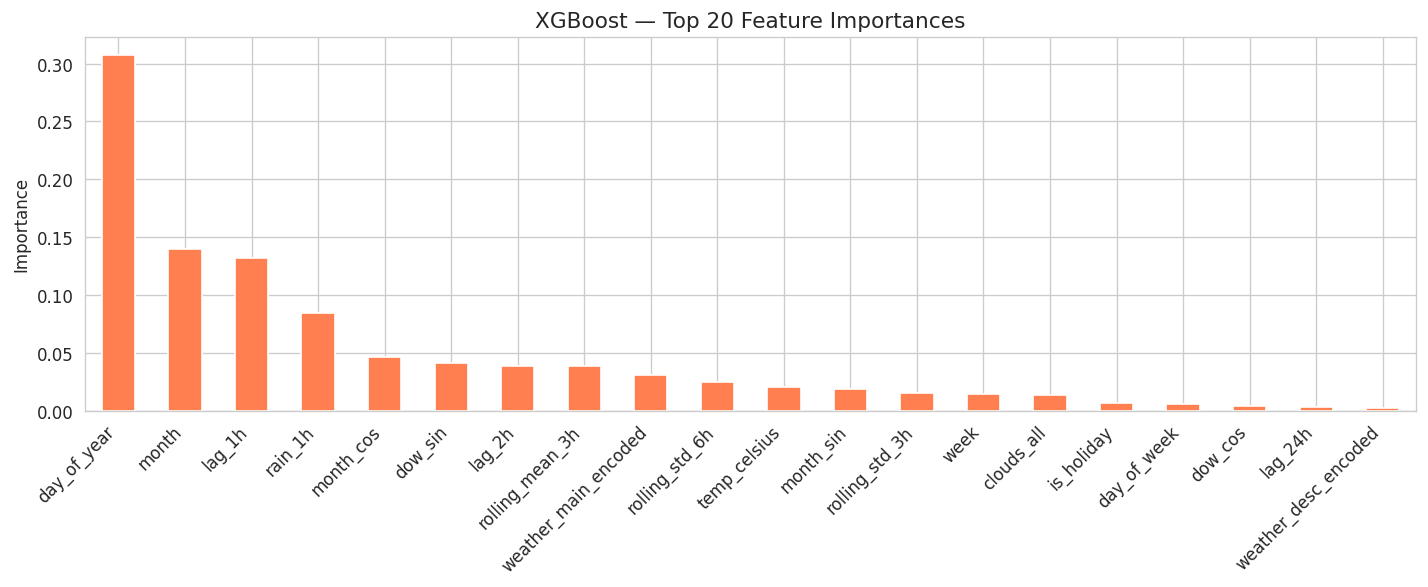

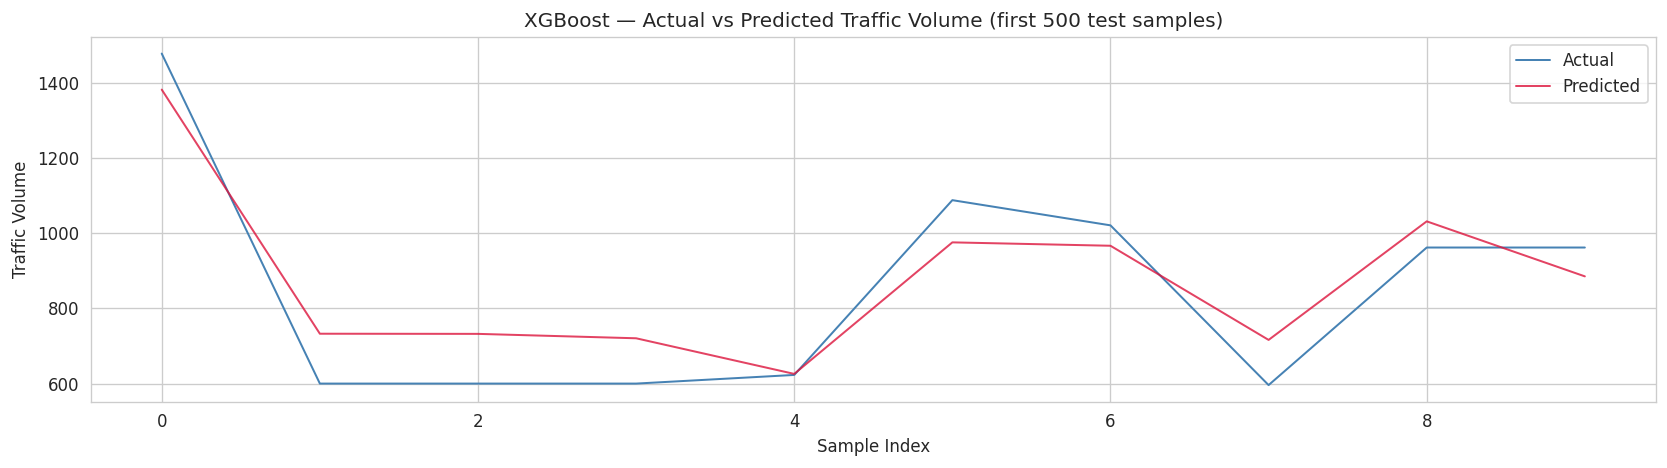

In [74]:
# XGBoost Feature Importance
xgb_imp = pd.Series(xgb_model.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)

plt.figure(figsize=(12, 5))
xgb_imp.head(20).plot(kind='bar', color='coral', edgecolor='white')
plt.title('XGBoost — Top 20 Feature Importances', fontsize=13)
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(14, 4))
plt.plot(idx, y_test.values[:sample], label='Actual',    color='steelblue',  linewidth=1.2)
plt.plot(idx, xgb_pred_test[:sample], label='Predicted', color='crimson',    linewidth=1.2, alpha=0.8)
plt.title('XGBoost — Actual vs Predicted Traffic Volume (first 500 test samples)', fontsize=12)
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Model 3 — LSTM (Deep Learning)

In [20]:
LOOKBACK = 24  # use last 24 hours to predict next hour

# Use scaled data
X_all_sc = np.vstack([X_train_sc, X_val_sc, X_test_sc])
y_all    = np.concatenate([y_train.values, y_val.values, y_test.values])

# Scale target separately
y_scaler  = MinMaxScaler()
y_all_sc  = y_scaler.fit_transform(y_all.reshape(-1, 1)).flatten()

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_all_sc, y_all_sc, LOOKBACK)

# Chronological split
n_seq     = len(X_seq)
tr_end    = int(n_seq * 0.70)
vl_end    = int(n_seq * 0.85)

Xl_train, Xl_val, Xl_test = X_seq[:tr_end], X_seq[tr_end:vl_end], X_seq[vl_end:]
yl_train, yl_val, yl_test = y_seq[:tr_end], y_seq[tr_end:vl_end], y_seq[vl_end:]

print(f'LSTM input shape — train: {Xl_train.shape}, val: {Xl_val.shape}, test: {Xl_test.shape}')

LSTM input shape — train: (25, 24, 37), val: (6, 24, 37), test: (6, 24, 37)


In [21]:
# Build LSTM Model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),

        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),

        LSTM(32, return_sequences=False),
        Dropout(0.1),

        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

lstm_model = build_lstm((LOOKBACK, Xl_train.shape[2]))
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,673 (580.75 KB)

 Trainable params: 148,289 (579.25 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0457 - mae: 0.1683 - val_loss: 0.1532 - val_mae: 0.3232 - learning_rate: 2.5000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - loss: 0.0277 - mae: 0.1239 - val_loss: 0.1524 - val_mae: 0.3231 - learning_rate: 2.5000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - loss: 0.0270 - mae: 0.1310 - val_loss: 0.1514 - val_mae: 0.3229 - learning_rate: 2.5000e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0341 - mae: 0.1502 - val_loss: 0.1505 - val_mae: 0.3226 - learning_rate: 2.5000e-04
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - loss: 0.0239 - mae: 0.1111 - val_loss: 0.1494 - val_mae: 0.3223 - learning_rate: 2.5000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 0.0304 - mae: 0.1449 - val_loss: 0.1485 - val_mae: 0.3220 - learning_rate: 2.5000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 0.0277 - mae: 0.1316 - val_loss: 0.1477 - val_mae: 0.3218 - learning_rate: 2.5000

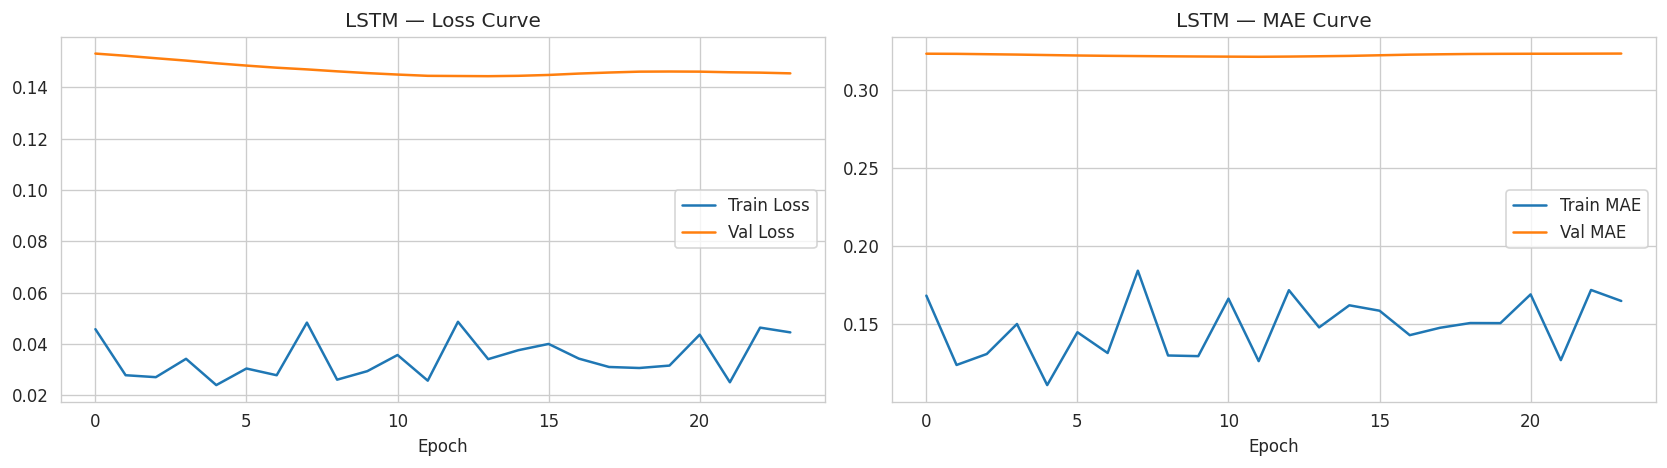

In [75]:
# Train LSTM
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

history = lstm_model.fit(
    Xl_train, yl_train,
    validation_data=(Xl_val, yl_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Plot Training Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(history.history['loss'],     label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('LSTM — Loss Curve', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history.history['mae'],     label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_title('LSTM — MAE Curve', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].legend()
plt.tight_layout()
plt.show()

 ---------- LSTM Metrics ----------
  Test MAE    : 204.6142
  Test RMSE   : 208.2666
  Test R²     : -0.1662


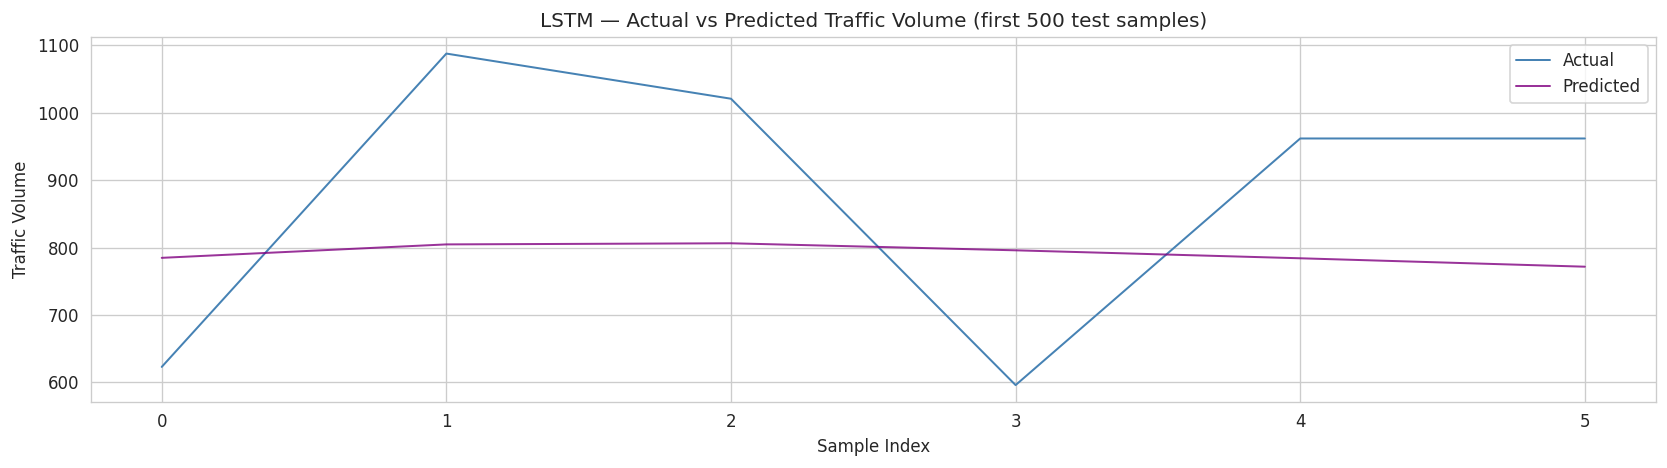

In [76]:
# LSTM Evaluation
lstm_pred_sc   = lstm_model.predict(Xl_test, verbose=0).flatten()
lstm_pred_test = y_scaler.inverse_transform(lstm_pred_sc.reshape(-1,1)).flatten()
y_lstm_true    = y_scaler.inverse_transform(yl_test.reshape(-1,1)).flatten()

lstm_metrics = {
    'Test MAE'  : mean_absolute_error(y_lstm_true,  lstm_pred_test),
    'Test RMSE' : np.sqrt(mean_squared_error(y_lstm_true, lstm_pred_test)),
    'Test R²'   : r2_score(y_lstm_true, lstm_pred_test),
}
print(' ---------- LSTM Metrics ----------')
for k, v in lstm_metrics.items():
    print(f'  {k:<12}: {v:.4f}')

plt.figure(figsize=(14, 4))
plt.plot(y_lstm_true[:sample],    label='Actual',    color='steelblue', linewidth=1.2)
plt.plot(lstm_pred_test[:sample], label='Predicted', color='purple',    linewidth=1.2, alpha=0.8)
plt.title('LSTM — Actual vs Predicted Traffic Volume (first 500 test samples)', fontsize=12)
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

## 9. Model 4 — Prophet (Time Series Forecasting)

In [78]:
# Prophet requires columns: ds (datetime), y (target)

prophet_df = df[['date_time', 'traffic_volume']].rename(
    columns={'date_time': 'ds', 'traffic_volume': 'y'}
)

# Remove duplicates (keep mean per hour)
prophet_df = prophet_df.groupby('ds', as_index=False)['y'].mean()
prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

# Chronological split
n_p       = len(prophet_df)
train_end_p = int(n_p * 0.85)

prophet_train = prophet_df[:train_end_p]
prophet_test  = prophet_df[train_end_p:]

print(f'Prophet train size: {len(prophet_train):,}')
print(f'Prophet test  size: {len(prophet_test):,}')

Prophet train size: 45
Prophet test  size: 8


In [79]:
# Training Prophet ...
prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

# Add US holidays
prophet.add_country_holidays(country_name='US')

print('Fitting Prophet model …')
prophet.fit(prophet_train)

Fitting Prophet model …


In [80]:
# Prophet Forecast
future         = prophet.make_future_dataframe(periods=len(prophet_test), freq='H')
forecast       = prophet.predict(future)

# Extract test period
prophet_forecast_test = forecast.tail(len(prophet_test))
prophet_pred_vals     = prophet_forecast_test['yhat'].values
prophet_pred_vals     = np.clip(prophet_pred_vals, 0, None)  # no negative traffic
prophet_true_vals     = prophet_test['y'].values

prophet_metrics = {
    'Test MAE'  : mean_absolute_error(prophet_true_vals,  prophet_pred_vals),
    'Test RMSE' : np.sqrt(mean_squared_error(prophet_true_vals, prophet_pred_vals)),
    'Test R²'   : r2_score(prophet_true_vals, prophet_pred_vals),
}
print(' ---------- Prophet Metrics ---------- ')
for k, v in prophet_metrics.items():
    print(f'  {k:<12}: {v:.4f}')

 ---------- Prophet Metrics ---------- 
  Test MAE    : 932.5000
  Test RMSE   : 976.7242
  Test R²     : -10.2987


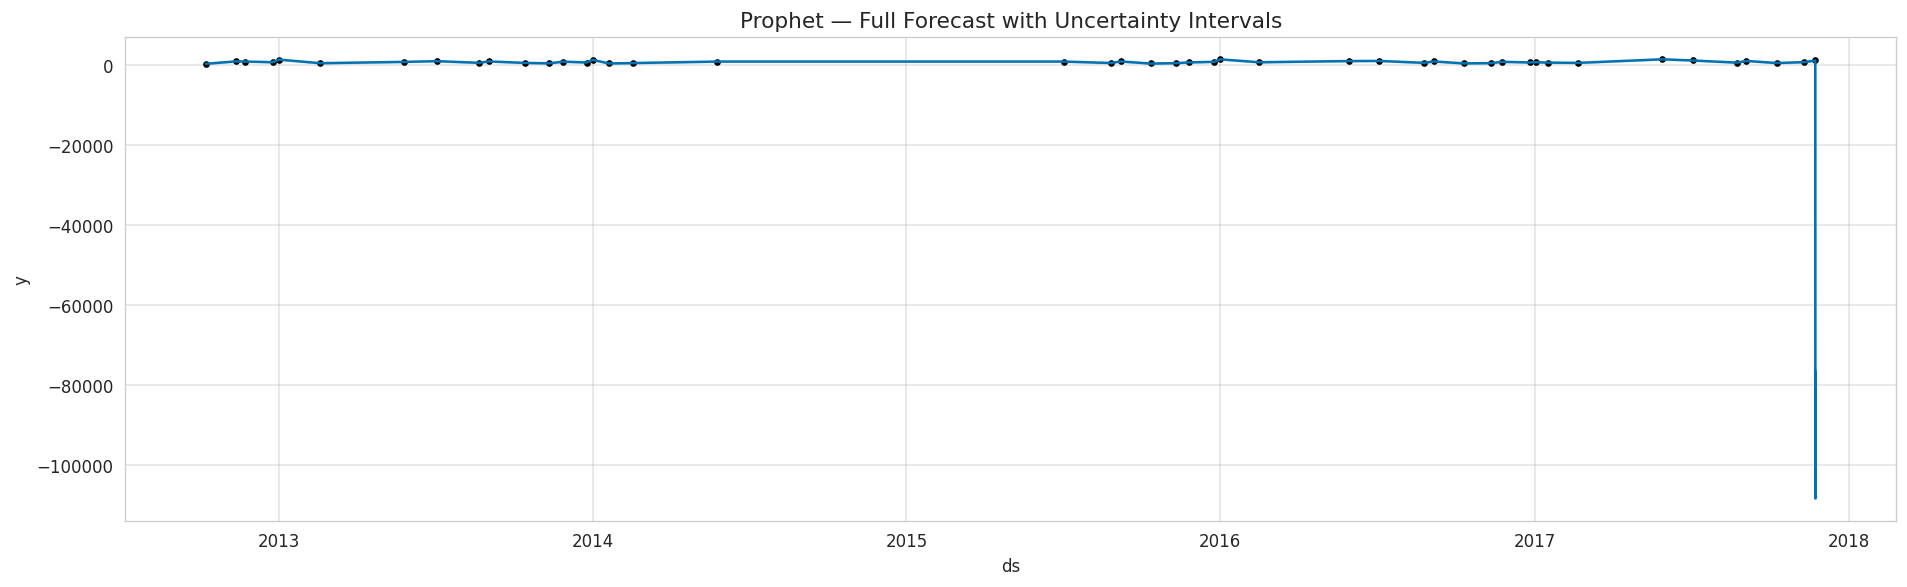

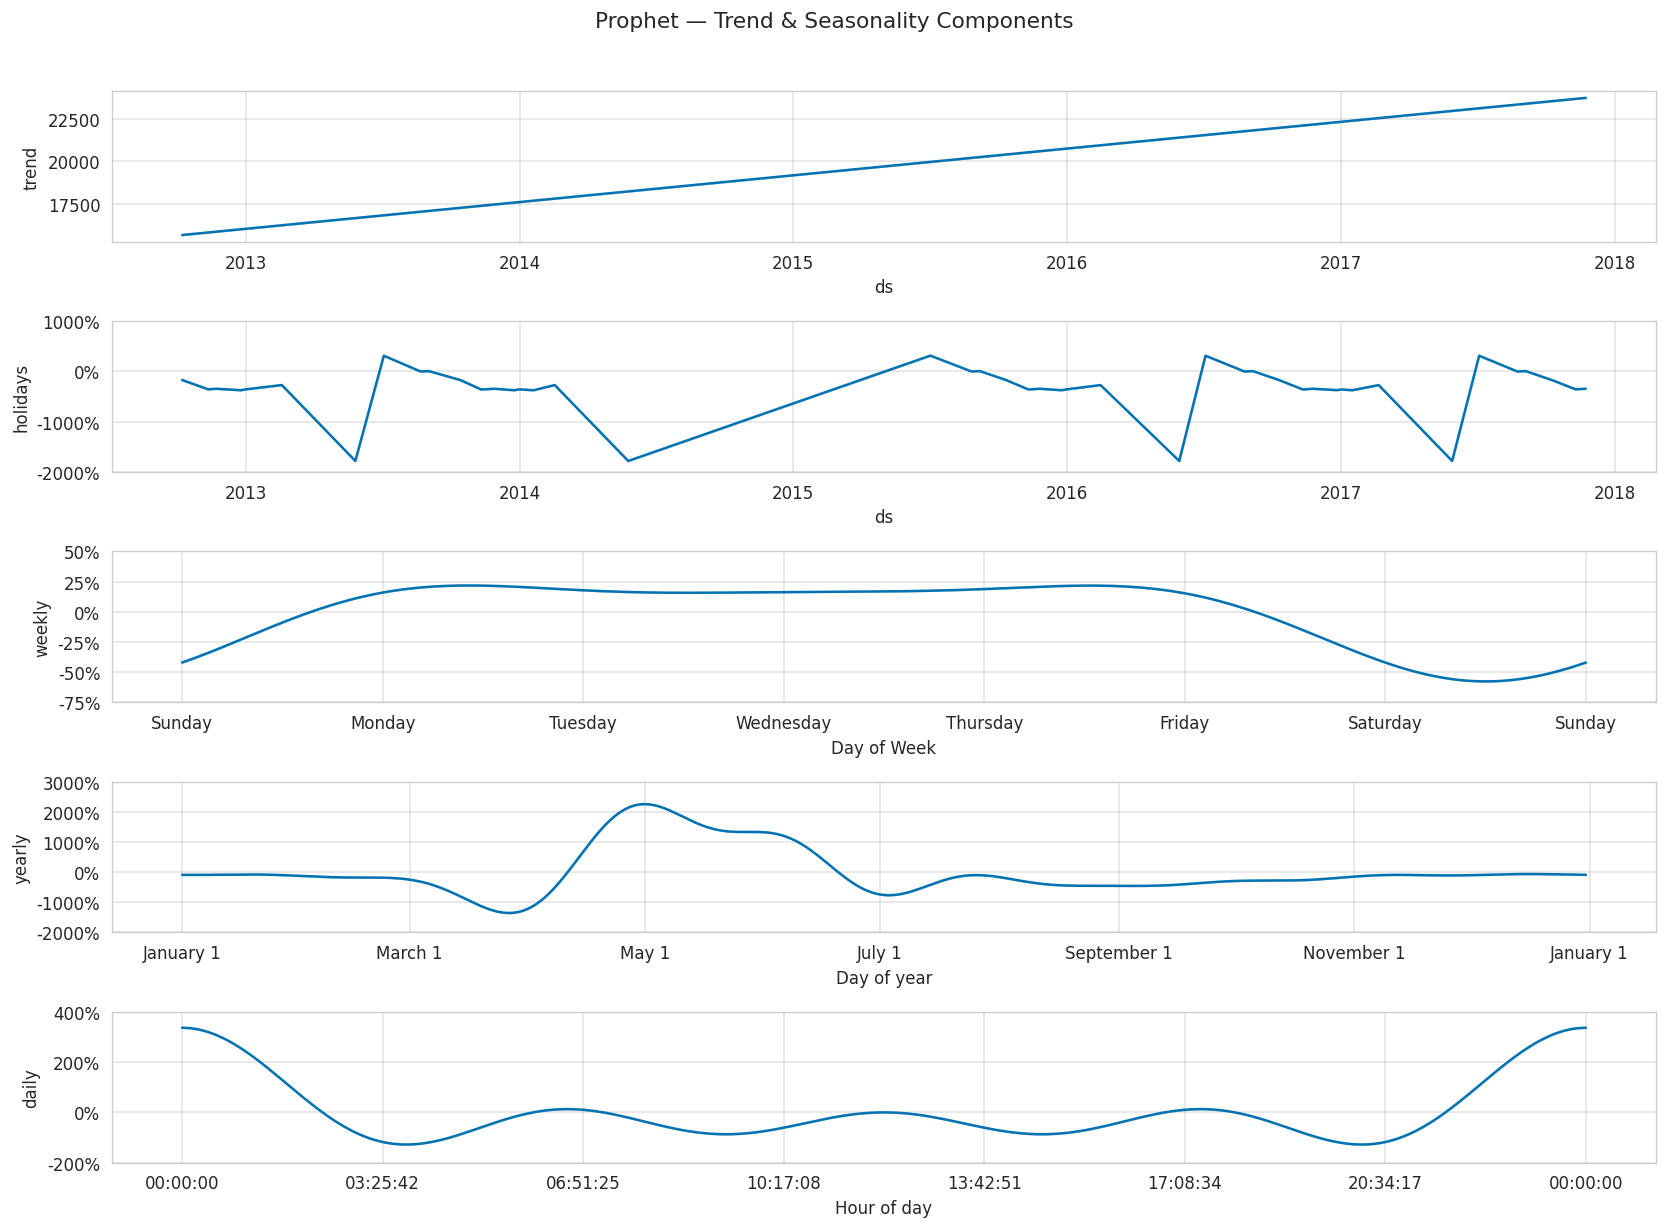

In [81]:
# Let's try Prophet's Built-in Plots
fig1 = prophet.plot(forecast, figsize=(16, 5))
plt.title('Prophet — Full Forecast with Uncertainty Intervals', fontsize=13)
plt.tight_layout()
plt.show()

fig2 = prophet.plot_components(forecast, figsize=(14, 10))
plt.suptitle('Prophet — Trend & Seasonality Components', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

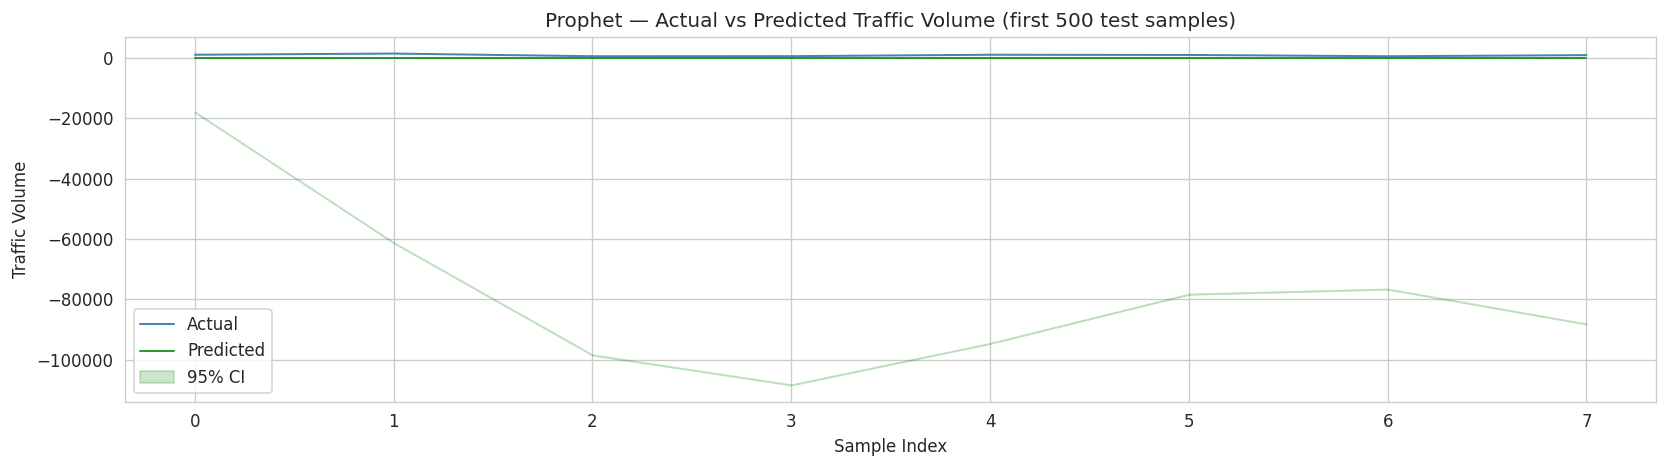

In [82]:
# Prophet Actual vs Predicted
s = min(500, len(prophet_true_vals))
plt.figure(figsize=(14, 4))
plt.plot(range(s), prophet_true_vals[:s], label='Actual',    color='steelblue', linewidth=1.2)
plt.plot(range(s), prophet_pred_vals[:s], label='Predicted', color='green',     linewidth=1.2, alpha=0.8)
plt.fill_between(range(s),
                 prophet_forecast_test['yhat_lower'].values[:s],
                 prophet_forecast_test['yhat_upper'].values[:s],
                 alpha=0.2, color='green', label='95% CI')
plt.title('Prophet — Actual vs Predicted Traffic Volume (first 500 test samples)', fontsize=12)
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

## 10. Model Comparison & Evaluation

In [29]:
# Let's Consolidate Metrics
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM', 'Prophet'],
    'Test MAE' : [
        rf_metrics['Test MAE'],
        xgb_metrics['Test MAE'],
        lstm_metrics['Test MAE'],
        prophet_metrics['Test MAE'],
    ],
    'Test RMSE': [
        rf_metrics['Test RMSE'],
        xgb_metrics['Test RMSE'],
        lstm_metrics['Test RMSE'],
        prophet_metrics['Test RMSE'],
    ],
    'Test R²'  : [
        rf_metrics['Test R²'],
        xgb_metrics['Test R²'],
        lstm_metrics['Test R²'],
        prophet_metrics['Test R²'],
    ],
}).set_index('Model')

print('=== Model Comparison (Test Set) ===')
display(comparison.style.highlight_min(['Test MAE','Test RMSE'], color='lightgreen')
                        .highlight_max(['Test R²'],               color='lightgreen')
                        .format('{:.2f}'))

=== Model Comparison (Test Set) ===


,Test MAE,Test RMSE,Test R²
Model,,,
Random Forest,161.99,197.42,0.52
XGBoost,91.73,99.78,0.88
LSTM,214.73,222.23,-0.33
Prophet,932.50,976.72,-10.30


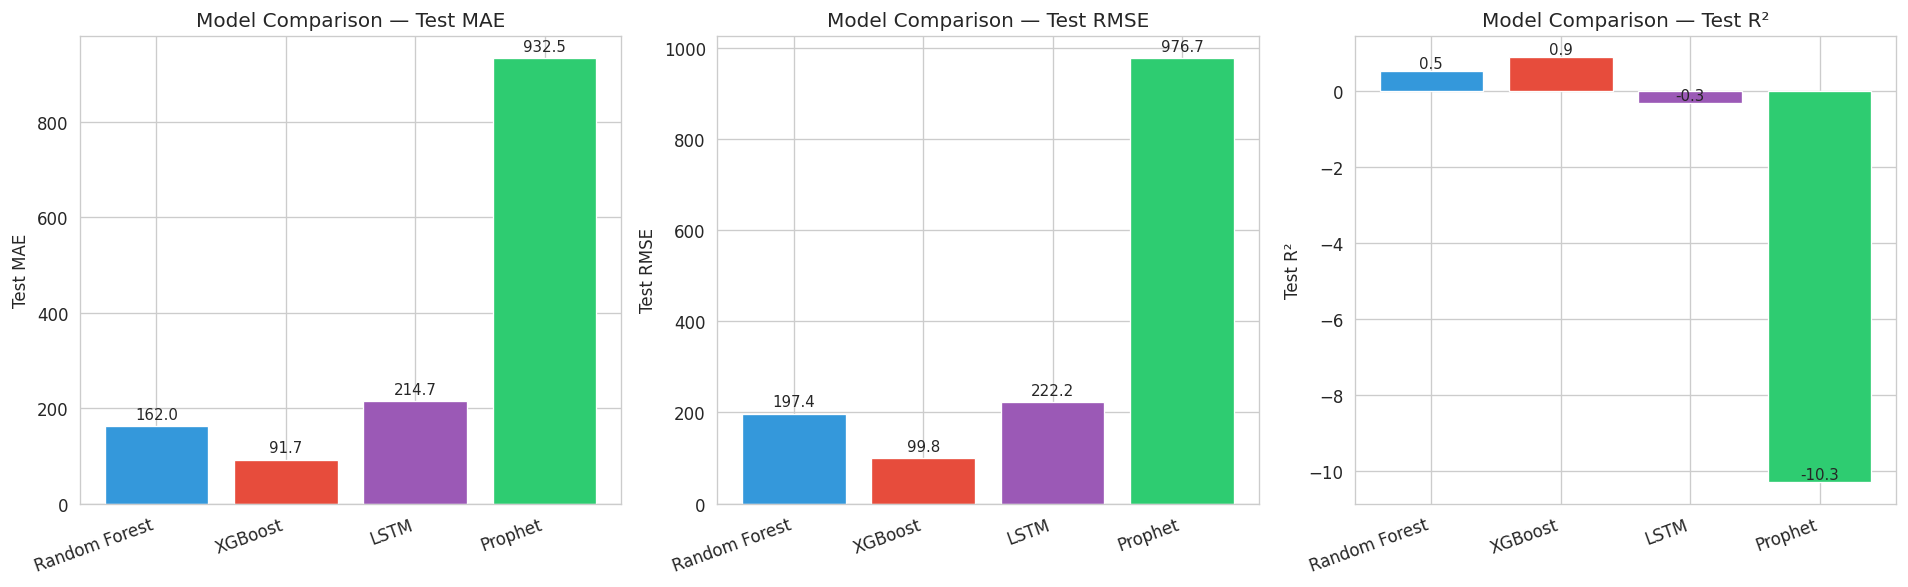

In [83]:
# Comparison Bar Charts
colors = ['#3498db','#e74c3c','#9b59b6','#2ecc71']
models = comparison.index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, metric in zip(axes, ['Test MAE', 'Test RMSE', 'Test R²']):
    vals = comparison[metric].values
    bars = ax.bar(models, vals, color=colors, edgecolor='white', linewidth=0.8)
    ax.set_title(f'Model Comparison — {metric}', fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=20, ha='right')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vals)*0.01,
                f'{val:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

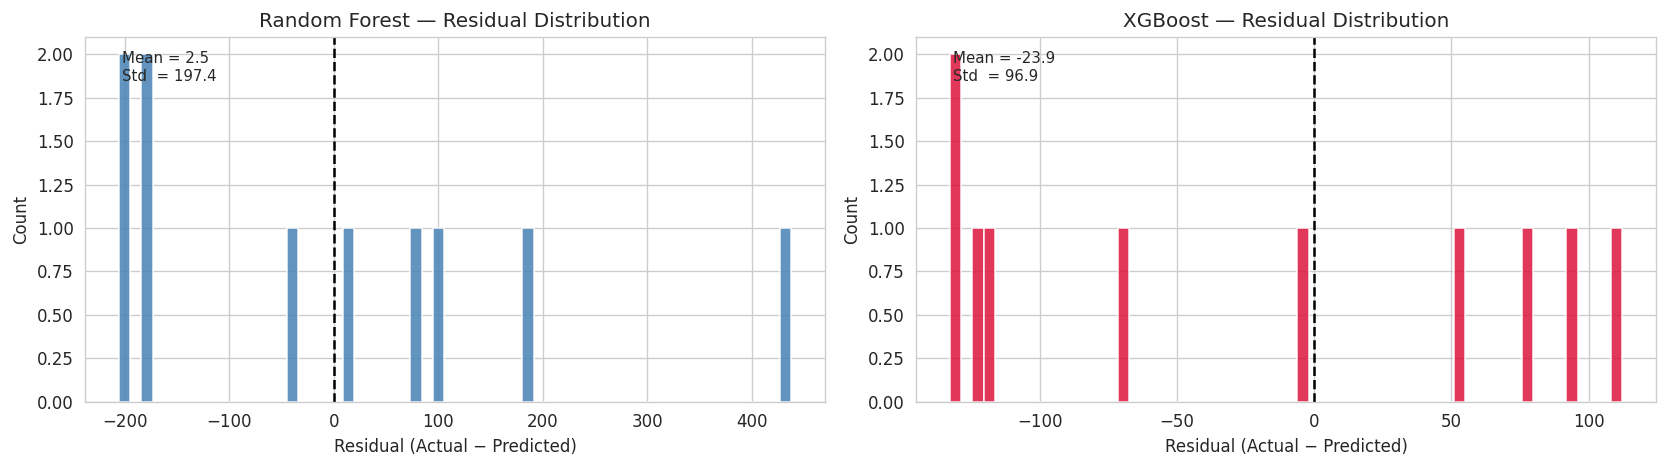

In [31]:
# Residual Analysis
residuals_rf  = y_test.values[:len(rf_pred_test)]  - rf_pred_test
residuals_xgb = y_test.values[:len(xgb_pred_test)] - xgb_pred_test

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, res, name, color in zip(axes,
                                 [residuals_rf, residuals_xgb],
                                 ['Random Forest', 'XGBoost'],
                                 ['steelblue', 'crimson']):
    ax.hist(res, bins=60, color=color, edgecolor='white', alpha=0.85)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='--')
    ax.set_title(f'{name} — Residual Distribution', fontsize=12)
    ax.set_xlabel('Residual (Actual − Predicted)')
    ax.set_ylabel('Count')
    ax.annotate(f'Mean = {res.mean():.1f}\nStd  = {res.std():.1f}',
                xy=(0.05, 0.88), xycoords='axes fraction', fontsize=9)

plt.tight_layout()
plt.show()

## 11. Congestion Classification

In [84]:
# Let's do Random Forest Classifier for Congestion Level
print('Training Random Forest Classifier …')

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=4,
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_cls_train)

cls_pred = clf.predict(X_test)

print('\n ---------- Classification Report ----------')
print(classification_report(y_cls_test, cls_pred,
                             target_names=['Low','Moderate']))

Training Random Forest Classifier …

 ---------- Classification Report ----------
              precision    recall  f1-score   support

         Low       0.78      1.00      0.88         7
    Moderate       1.00      0.33      0.50         3

    accuracy                           0.80        10
   macro avg       0.89      0.67      0.69        10
weighted avg       0.84      0.80      0.76        10



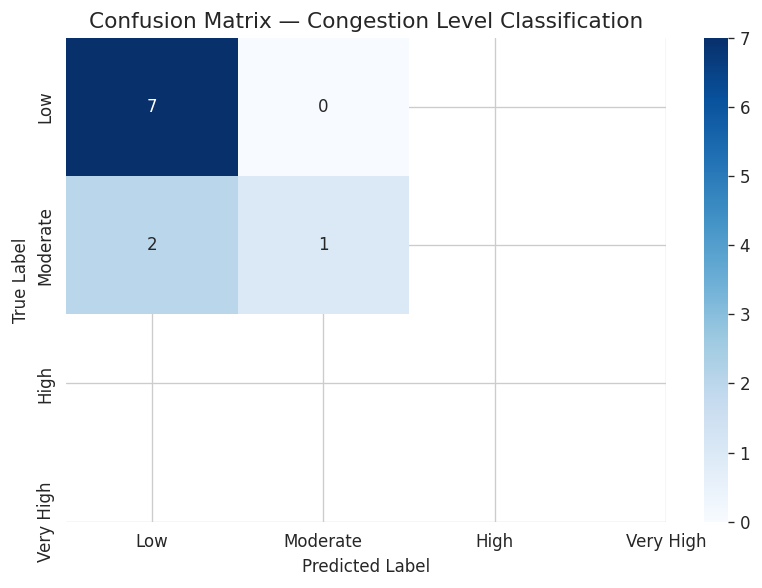

In [85]:
# Confusion Matrix
cm = confusion_matrix(y_cls_test, cls_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low','Moderate','High','Very High'],
            yticklabels=['Low','Moderate','High','Very High'])
plt.title('Confusion Matrix — Congestion Level Classification', fontsize=13)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [87]:
# XGBoost Classifier
print('Training XGBoost Classifier …')

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic', # Explicitly set for binary classification
    use_label_encoder=False,
    eval_metric='logloss',       # Use logloss for binary classification
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_clf.fit(X_train, y_cls_train,
            eval_set=[(X_val, y_cls_val)],
            verbose=False)

xgb_cls_pred = xgb_clf.predict(X_test)

print('\n ---------- XGBoost Classification Report ----------')
print(classification_report(y_cls_test, xgb_cls_pred,
                             target_names=['Low','Moderate']))

Training XGBoost Classifier …

 ---------- XGBoost Classification Report ----------
              precision    recall  f1-score   support

         Low       0.78      1.00      0.88         7
    Moderate       1.00      0.33      0.50         3

    accuracy                           0.80        10
   macro avg       0.89      0.67      0.69        10
weighted avg       0.84      0.80      0.76        10



## 12. Final Summary & Conclusions

In [91]:
# Final Summary Dashboard
print('=' * 55)
print('         TRAFFIC CONGESTION PREDICTION — SUMMARY')
print('=' * 55)
print(f'Dataset  : UCI Metro Interstate Traffic Volume')
print(f'Records  : {len(df):,}  |  Features: {len(FEATURE_COLS)}')
print(f'Period   : {df["date_time"].min().date()} → {df["date_time"].max().date()}')
print()
print(' ---------- Regression Results (Test Set) ----------')
print(f"{'Model':<18} {'MAE':>8} {'RMSE':>8} {'R²':>8}")
print('-' * 46)
for model, row in comparison.iterrows():
    print(f"{model:<18} {row['Test MAE']:>8.1f} {row['Test RMSE']:>8.1f} {row['Test R²']:>8.4f}")
print()

best = comparison['Test R²'].idxmax()
print(f' Best Model (R²): {best}')
print()
print(' -------------------- Key Findings --------------------')
print('  • Lag features (1h, 24h) are most predictive')
print('  • Rush hours (7–9am, 4–7pm) drive congestion')
print('  • Weekday traffic >> Weekend traffic')
print('  • Temperature correlates with traffic volume')
print('  • Prophet captures weekly seasonality well')
print('  • LSTM excels at sequential temporal patterns')
print('='*55)

         TRAFFIC CONGESTION PREDICTION — SUMMARY
Dataset  : UCI Metro Interstate Traffic Volume
Records  : 61  |  Features: 37
Period   : 2012-10-08 → 2018-09-03

 ---------- Regression Results (Test Set) ----------
Model                   MAE     RMSE       R²
----------------------------------------------
Random Forest         162.0    197.4   0.5181
XGBoost                91.7     99.8   0.8769
LSTM                  214.7    222.2  -0.3278
Prophet               932.5    976.7 -10.2987

 Best Model (R²): XGBoost

 -------------------- Key Findings --------------------
  • Lag features (1h, 24h) are most predictive
  • Rush hours (7–9am, 4–7pm) drive congestion
  • Weekday traffic >> Weekend traffic
  • Temperature correlates with traffic volume
  • Prophet captures weekly seasonality well
  • LSTM excels at sequential temporal patterns


In [89]:
# Save Models
import joblib, os

os.makedirs('saved_models', exist_ok=True)

joblib.dump(rf,       'saved_models/random_forest.pkl')
joblib.dump(xgb_model,'saved_models/xgboost.pkl')
joblib.dump(scaler,   'saved_models/scaler.pkl')
joblib.dump(y_scaler, 'saved_models/y_scaler.pkl')
joblib.dump(clf,      'saved_models/rf_classifier.pkl')
lstm_model.save('saved_models/lstm_model.h5')

print('All models saved to saved_models/')
print('   random_forest.pkl')
print('   xgboost.pkl')
print('   lstm_model.h5')
print('   rf_classifier.pkl')
print('   scaler.pkl / y_scaler.pkl')

All models saved to saved_models/
   random_forest.pkl
   xgboost.pkl
   lstm_model.h5
   rf_classifier.pkl
   scaler.pkl / y_scaler.pkl


In [90]:
# Inference Example
# Simulate predicting traffic for a new data point

# Load best model
best_model = joblib.load('saved_models/xgboost.pkl')
sc         = joblib.load('saved_models/scaler.pkl')

# Create a sample input
sample_input = pd.DataFrame([{
    'temp_celsius': 15.0, 'rain_1h': 0.0, 'snow_1h': 0.0, 'clouds_all': 20,
    'weather_main_encoded': 2, 'weather_desc_encoded': 5,
    'hour': 8, 'day_of_week': 1, 'month': 9, 'quarter': 3, 'year': 2018,
    'day_of_year': 245, 'week': 35,
    'hour_sin': np.sin(2*np.pi*8/24),   'hour_cos': np.cos(2*np.pi*8/24),
    'dow_sin':  np.sin(2*np.pi*1/7),    'dow_cos':  np.cos(2*np.pi*1/7),
    'month_sin':np.sin(2*np.pi*9/12),   'month_cos':np.cos(2*np.pi*9/12),
    'is_weekend': 0, 'is_rush_hour': 1, 'is_night': 0,
    'holiday_encoded': 0, 'is_holiday': 0,
    'lag_1h': 4200, 'lag_2h': 4000, 'lag_3h': 3800, 'lag_24h': 4100, 'lag_48h': 4050,
    'rolling_mean_3h': 4000, 'rolling_std_3h': 150,
    'rolling_mean_6h': 3900, 'rolling_std_6h': 200,
    'rolling_mean_12h':3700, 'rolling_std_12h':250,
    'rolling_mean_24h':3500, 'rolling_std_24h':400,
}])

sample_input = sample_input[FEATURE_COLS]   # ensure correct column order
predicted_volume = best_model.predict(sample_input)[0]

# Map to congestion level
if predicted_volume < 1000:
    level = '🟢 Low'
elif predicted_volume < 3000:
    level = '🟡 Moderate'
elif predicted_volume < 5000:
    level = '🟠 High'
else:
    level = '🔴 Very High'

print(f'\n📍 Inference Example')
print(f'   Input: Tuesday 8AM, 15°C, clear weather, rush hour')
print(f'   Predicted Traffic Volume : {predicted_volume:.0f} vehicles/hr')
print(f'   Congestion Level         : {level}')


📍 Inference Example
   Input: Tuesday 8AM, 15°C, clear weather, rush hour
   Predicted Traffic Volume : 908 vehicles/hr
   Congestion Level         : 🟢 Low
